# Blood Donation challenge

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np

## Get data

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data

--2019-08-01 09:13:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12843 (13K) [application/x-httpd-php]
Saving to: ‘transfusion.data’

transfusion.data    100%[===================>]  12.54K  --.-KB/s    in 0s      

2019-08-01 09:13:09 (86.5 MB/s) - ‘transfusion.data’ saved [12843/12843]



In [0]:
!ls

sample_data  transfusion.data


In [0]:
column_names = ["Recency", "Frequency", "Amount", "Times", "Donation"]
data = pd.read_csv("transfusion.data", names=column_names, header=0)
data.head()

,Recency,Frequency,Amount,Times,Donation
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Outliners

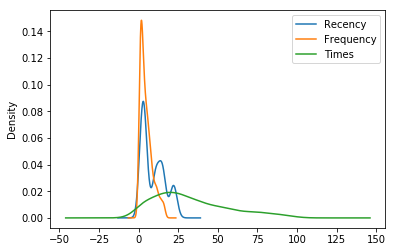

In [0]:
columns = ['Recency', 'Frequency', 'Times']
remove_idx = []
outliner_min_factor = 1.8
outliner_max_factor = 1.8
for col in columns:
    series_desc = data.describe()[col]
    iqr = series_desc['75%']-series_desc['25%']
    outliner_min = series_desc['25%']-(iqr*outliner_min_factor)
    outliner_max = series_desc['75%']+(iqr*outliner_max_factor)
    remove_idx.append(data[data[col]<outliner_min].index.tolist())
    remove_idx.append(data[data[col]>outliner_max].index.tolist())

[data.drop(idx, inplace=True) for idx in remove_idx]
data.reset_index(inplace=True, drop=True)

data[columns].plot.kde()

In [0]:
features = data[columns]
target = data['Donation']

## Distribution fixing

In [0]:
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer

In [0]:
features_transformed = features.values

In [0]:
binning_transformer = KBinsDiscretizer(n_bins=10, encode='ordinal')
binning = binning_transformer.fit_transform(features_transformed)
features_transformed[:,0] = binning[:,0]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [0]:
power_transformer = PowerTransformer(standardize=False)
features_transformed = power_transformer.fit_transform(features_transformed)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98f5595278>,
      dtype=object)

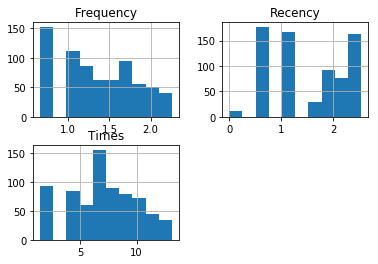

In [0]:
df_features_transformed = pd.DataFrame(features_transformed, columns=['Recency', 'Frequency', 'Times'])
df_features_transformed.hist()

## Oversampling

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


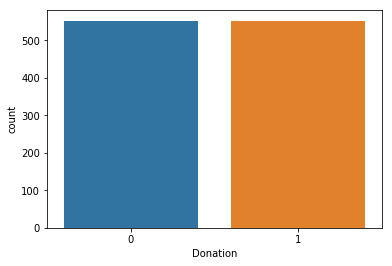

In [0]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42, k_neighbors=5)
df_features_transformed, y_over_sampled = over_sampling.fit_resample(df_features_transformed, target)
sns.countplot(x='Donation', data=pd.DataFrame(y_over_sampled, columns=['Donation']));

## Clean data output

In [0]:
output_data = np.column_stack((df_features_transformed, y_over_sampled))
output = pd.DataFrame(output_data, columns=['Recency', 'Frequency', 'Times', 'Donation'])
output.head()

,Recency,Frequency,Times,Donation
0,0.000000,2.137547,7.095816,1.0
1,0.000000,2.260914,7.960593,1.0
2,1.218818,1.412639,2.256640,0.0
3,0.739778,1.758923,4.875792,1.0
4,0.000000,2.089401,7.960593,0.0


## Model - XGBoost

In [0]:
# x = output.drop('Donation', axis=1)
# y = output.Donation

In [0]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

In [0]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from xgboost import XGBClassifier

# params_model1 = {
#     'booster': ['dart', 'gbtree'],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'min_child_weight': [1,5,10,15,20],
#     'gamma': [0, 0.5, 1, 1.5, 2, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'max_delta_step': [0, 1, 2,3,5, 10],
#     'base_score': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
#     'reg_alpha':[0, 0.5, 1, 1.5, 2],
#     'reg_lambda': [0, 0.5, 1, 1.5, 2]
# }

# model1 = XGBClassifier(n_estimators=1000, learning_rate=0.01, subsample=0.8, 
#                       gamma=0, max_depth=4, colsample_bytree=1, )
# rs_model1 = RandomizedSearchCV(model1, param_distributions=params_model1, n_iter=10, 
#                                scoring='roc_auc', n_jobs=4, cv=skf.split(x,y), verbose=3, random_state=1001 )
# rs_model1.fit(x,y)

# rs_model1.best_score_, rs_model1.best_params_ 

## AutoML - H2O

In [0]:
! apt-get install default-jre
! java -version
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
openjdk version "11.0.3" 2019-04-16
OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1)
OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
     |████████████████████████████████| 122.7MB 203kB/s 
  Stored in directory: /root/.cache/pip/wheels/76/01/62/d6b7bfc9d599463401118db95eab37c134a6f24040828d31ab
Successfully built h2o


In [0]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpidt3kvhc
  JVM stdout: /tmp/tmpidt3kvhc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpidt3kvhc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_unknownUser_oatne3
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
h2o_data = h2o.H2OFrame(output)
h2o_data[3] = h2o_data[3].asfactor()
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(y = 3, training_frame = h2o_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
lb = aml.leaderboard
lb

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190801_091352,0.896422,0.406105,0.184783,0.358389,0.128443
StackedEnsemble_BestOfFamily_AutoML_20190801_091352,0.893717,0.409646,0.1875,0.360592,0.130026
StackedEnsemble_AllModels_AutoML_20190801_091352,0.893717,0.409646,0.1875,0.360592,0.130026
GBM_3_AutoML_20190801_091352,0.880684,0.435507,0.197464,0.37316,0.139248
DRF_1_AutoML_20190801_091352,0.879772,0.439708,0.197464,0.375662,0.141122
GBM_4_AutoML_20190801_091352,0.879657,0.434405,0.220109,0.374295,0.140097
GBM_2_AutoML_20190801_091352,0.878036,0.440323,0.20471,0.376853,0.142018
XGBoost_3_AutoML_20190801_091352,0.85629,0.481346,0.224638,0.395488,0.156411
XGBoost_1_AutoML_20190801_091352,0.843297,0.50094,0.234601,0.404952,0.163986
XGBoost_2_AutoML_20190801_091352,0.814156,0.534899,0.270833,0.422185,0.17824
